**Introduction**
This project aims to study the classification of requests to a web application server, in particular, classify requests as legitimate or malicious using only the URL. The dataset used is a merge of various smaller similar public datasets and can be found on Github: https://github.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall


In [37]:
import os
import urllib.parse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import pandas
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay as display_cm
from sklearn import preprocessing
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM as OSVM
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC as SVM
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_text, DecisionTreeClassifier as DTC
from scipy.stats import wilcoxon
from matplotlib.ticker import PercentFormatter
from imblearn.under_sampling import RandomUnderSampler

#load the dataset
directory = str(os.getcwd())
filepath = os.path.join(directory, 'goodqueries.txt')
with open(filepath,'r') as f:
    goodlines = f.readlines()
filepath = os.path.join(directory, 'badqueries.txt')
with open(filepath,'r') as f:
    badlines = f.readlines()

print(goodlines[0])
print(badlines[0])


lines = goodlines + badlines
labels = [ "normal" for _ in range(len(goodlines))] + [ "malicious" for _ in range(len(badlines))]

#remove url encoding and parse the url
urlstr = [ str(urllib.parse.unquote(d)) for d in lines]
urls = [ urllib.parse.urlparse(d) for d in lines]

df = pandas.DataFrame(urls)
df.insert(0, 'url', urlstr)
df["label"] = labels

df.sample(10)


/103886/

/top.php?stuff='uname >q36497765 #



,url,scheme,netloc,path,params,query,fragment,label
904877,/hwsubhed/\n,,,/hwsubhed/,,,,normal
1195137,/picture_manager/\n,,,/picture_manager/,,,,normal
67165,/critical-theory/\n,,,/critical-theory/,,,,normal
978124,/direction/index.php?repertoire_config=http://...,,,/direction/index.php,,repertoire_config=http://192.168.202.96:8080/s...,,normal
39653,/eeqwjkr7.aspx\n,,,/eeqwjkr7.aspx,,,,normal
1104041,/planet_leweb3/\n,,,/planet_leweb3/,,,,normal
592089,/javascript/cfdocs.stackdump\n,,,/javascript/cfdocs.stackdump,,,,normal
228072,/javascript/webdav.7z\n,,,/javascript/webdav.7z,,,,normal
408684,/pii.php\n,,,/pii.php,,,,normal
979242,/finepixz5fdth/\n,,,/finepixz5fdth/,,,,normal


**Preprocessing**
Duplicates are removed from the data frame, then meaningful features are extracted from the URLs. Characteristics of the URL that can be linked to an attack are: anomalous length, anomalous length of the query, and presence of keywords of SQL, Javascript, Bash, and HTML, which can reveal an attempt of injection.
The occurrence count of this keyword is taken as a feature. For Javascript, the complete list of keywords is used, plus selected words frequently used during injection attacks. For SQL a selection of more common keywords is used to improve performance. For Shell, a selection of keywords is taken from security checklists.


In [38]:
df = df.drop_duplicates(subset=['url'])
df.describe()

,url,scheme,netloc,path,params,query,fragment,label
count,1310471,1310471,1310471,1310471,1310471,1310471,1310471,1310471
unique,1310471,114,367,1266700,729,23140,723,2
top,/103886/\n,,,/main.php,,,,normal
freq,1,1310126,1309999,2533,1309551,1253572,1309640,1265974


In [40]:
#Counts thee occurrencies of strings from a list in a string
def count_occ(str_el, str_list):
    return reduce(lambda a, b: a + str_el.count(b), str_list, 0)
    

filepath = os.path.join(directory, 'SqlKeywordsRed.txt')
with open(filepath,'r') as f:
    sql_list = f.readlines()
sql_list = [l.lower() for l in sql_list] 
sql_list = [l.strip() for l in sql_list]

filepath = os.path.join(directory, 'JavascriptKeywords.txt')
with open(filepath,'r') as f:
    script_list = f.readlines()
script_list = [l.lower() for l in script_list]
script_list = [l.strip() for l in script_list]
script_list += ["script", "meta", "doctype", "entity", '>', '<', '<?php', '?>', 'shell_exec', 'link', 'img', 'href', 'src', '<tt>', '<map']
script_list = set(script_list)
script_list.discard("")
script_list = list(script_list)

shell_list = [')', '>', '/dev', '/bin', '/usr', 'bin/sh', '/local', '@', '|', '+', '#', '/etc', '/passwd', ']', '~', '<', '[', '{', '}', 'zip', 'nc', ';', '(', '*', '^', 'cp', '$', '!']

 


url_lower = df["url"].map(lambda x: x.lower()) #the urls are lowercased for easier comparision
df["sql"] = url_lower.map(lambda x: count_occ(x, sql_list))
df["script"] = url_lower.map(lambda x: count_occ(x, script_list))
df["shell"] = url_lower.map(lambda x: count_occ(x, shell_list))
df["query_len"] = df["query"].map(len)
df["query_len"] += df["params"].map(len) #the length of the parameter is added to thee length of the query
df["length"] = df["url"].map(len)


df.sample(10)


,url,scheme,netloc,path,params,query,fragment,label,sql,script,shell,query_len,length
540823,/42748-1/\n,,,/42748-1/,,,,normal,0,0,0,0,10
879998,/553223/\n,,,/553223/,,,,normal,0,0,0,0,9
689303,/javascript/req.msg\n,,,/javascript/req.msg,,,,normal,2,1,0,0,20
970665,/society_gifts/\n,,,/society_gifts/,,,,normal,0,1,0,0,16
1215702,/0321168925/\n,,,/0321168925/,,,,normal,0,0,0,0,13
325419,/mja0ntcz/\n,,,/mja0ntcz/,,,,normal,0,0,0,0,11
29434,/absolutlystoryofagir/\n,,,/absolutlystoryofagir/,,,,normal,1,0,0,0,23
482000,/24military/\n,,,/24military/,,,,normal,0,0,0,0,13
879295,/580742/\n,,,/580742/,,,,normal,0,0,0,0,9
265568,/pyxidessprint/\n,,,/pyxidessprint/,,,,normal,0,2,0,0,16


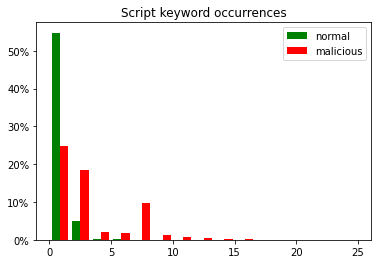

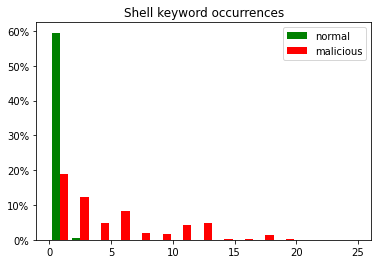

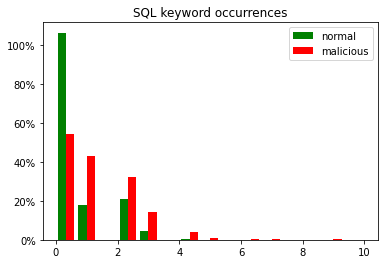

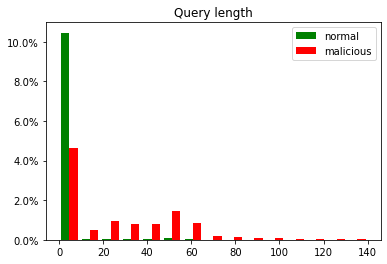

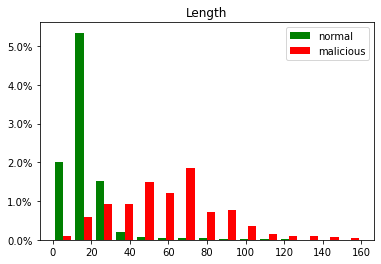

In [4]:
dg = df[df.label == 'normal']
db = df[df.label == 'malicious']
plt.title("Script keyword occurrences")
plt.hist([dg['script'], db['script']], density=True, label=['normal', 'malicious'], color=['g', 'r'], bins=15, range=(0,25))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()

plt.title("Shell keyword occurrences")
plt.hist([dg['shell'], db['shell']], density=True, label=['normal', 'malicious'], color=['g', 'r'], bins=15, range=(0,25))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()

plt.title("SQL keyword occurrences")
plt.hist([dg['sql'], db['sql']], density=True, label=['normal', 'malicious'], color=['g', 'r'], bins=15, range=(0,10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()

plt.title("Query length")
plt.hist([dg['query_len'], db['query_len']], density=True, label=['normal', 'malicious'], color=['g', 'r'], bins=15, range=(0,140))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()

plt.title("Length")
plt.hist([dg['length'], db['length']], density=True, label=['normal', 'malicious'], color=['g', 'r'], bins=15, range=(0,160))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()


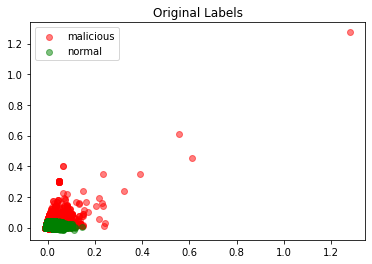

In [5]:
ds = df[["sql", "shell", "script", "length"]]
dsn = preprocessing.MinMaxScaler().fit_transform(ds)
pca = PCA(2)
dsp = pca.fit_transform(dsn)


filtered_label2 = dsp[df["label"] == "normal"]
filtered_label =  dsp[df["label"] == "malicious"]
plt.title("Original Labels")
plt.scatter(filtered_label[:,0] , filtered_label[:,1] , color = 'red', alpha=0.5, label = "malicious")
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'green', alpha=0.5, label = "normal")

plt.legend()
plt.show()

As the graphs show the distribution of this feature is different between legitimate and malicious URLs, but there is still a relevant superposition, so this feature is not enough to separate the two classes and not cover all kinds of attacks in the dataset.

**Classification**

The most common approach to counter these injection attacks is sanitization, so is not easy to find not ML-based classificators for comparison. This project implements a simple blacklist as a baseline for comparison. As base for the blacklist is used the collection of keywords of the features extraction phase. A more complex rule-based approach based on the same features may be possible. The Blacklist class is designed to mimic the Sklearn API for coherence.
Then the ML algorithms studied during the lectures are applied and compared.


Blacklist
Precision: 1.000000
Accuracy: 0.976558
Recall: 0.307744
F1-Score: 0.470649


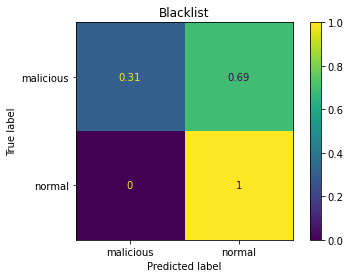

In [6]:
class Blacklist():
    def __init__(self, blist):
        self._blist = blist
    
    #returns 1 for malicious url else 0
    def validate(self, url):
        for s in self._blist:
            if s in url:
                return 1
        return 0
    
    def fit(self,X,y):
        X = [u.lower() for u in X]
        badword = set()
        goodword = set()

        badurls = [u for u, l in zip(X,y) if l == 1]
        goodurls = [u for u, l in zip(X,y) if l == 0]

        #select the keywords in the blacklist present in the bad examples
        for w in self._blist:
            for u in badurls:
                if w in u:
                    badword.add(w)
                    break
        #select the keywords in the blacklist present in the good examples
        for w in self._blist:
            for u in goodurls:
                if w in u:
                    goodword.add(w)
                    break
        
        #create the actual blacklist
        self._blist = badword.difference(goodword)

    
    def predict(self, X):
        X = [u.lower() for u in X]
        return [self.validate(u) for u in X]

blist = sql_list + script_list + shell_list


X = df[ "url"]
y = df["label"].map(lambda x: 1 if x == "malicious" else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


cls = Blacklist(blist)
cls.fit(X_train, y_train)

predicted = cls.predict(X_test)


print("\nBlacklist")
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Accuracy: %f" % metrics.accuracy_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
matrix = display_cm(metrics.confusion_matrix(y_test, predicted, normalize='true', labels=[1,0]), display_labels=['malicious', 'normal'])
matrix.plot()
matrix.ax_.set_title("Blacklist")
plt.show()

In [8]:
ds = df[["sql", "shell", "script", "length", "query_len"]]
lr = LogisticRegression()
nb = MultinomialNB()
svm = SVM()
nn = MLPClassifier(max_iter=20) #the iterations are limited for performance reasons but the model accuracy not increase a lot with more iterations
tree = DTC()

classifiers = [(nb, 'Naive Bayes'), (lr, 'Logistic Regression'), (tree, 'Decision Tree'), (nn, 'MLPClassifier')] 

labels = df["label"].map(lambda x: 1 if x == "malicious" else 0)

rus = RandomUnderSampler(sampling_strategy=0.2) #undersampling to reduce unbalance
X, y = rus.fit_resample(ds, labels)
result = []

for cls, name in classifiers:
    skfold=StratifiedKFold(random_state=42, shuffle=True)
    scores=cross_val_score(cls,X,y,cv=skfold, scoring='f1', n_jobs=4)
    result.append((name, np.mean(scores)))

svm = SVM()
classifiers = [(svm, 'SVM')] 

Xn = preprocessing.MinMaxScaler().fit_transform(X) # the dataset is normalized for SVM

for cls, name in classifiers:
    skfold=StratifiedKFold(random_state=42, shuffle=True)
    scores=cross_val_score(cls,Xn,y,cv=skfold, scoring='f1', n_jobs=4)
    result.append((name, np.mean(scores)))

result.sort(reverse=True, key=(lambda x: x[1]))
print("Classifier, F1-Score")
for r in result:
    print(f"{r[0]} {r[1]}")

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.wa

Classifier, F1-Score
Decision Tree 0.8889180702846298
MLPClassifier 0.8666021517987783
Naive Bayes 0.8153222792664151
Logistic Regression 0.795718523990643
SVM 0.7595566789524874


Precision: 0.740570
Accuracy: 0.984779
Recall: 0.840952
F1-Score: 0.787575


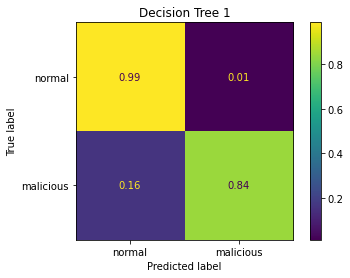

In [41]:
tree = DTC()
X_train, X_test, y_train, y_test = train_test_split(ds, labels, test_size=0.3)
rus = RandomUnderSampler(sampling_strategy=0.2) #undersampling to reduce unbalance
X_train, y_train = rus.fit_resample(X_train, y_train)
tree = tree.fit(X_train, y_train)
predicted = tree.predict(X_test)
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Accuracy: %f" % metrics.accuracy_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
matrix = metrics.confusion_matrix(y_test, predicted, normalize='true', labels=[0,1])
matrix = display_cm(matrix, display_labels=['normal', 'malicious'])
matrix.plot()
matrix.ax_.set_title("Decision Tree 1")
plt.show()



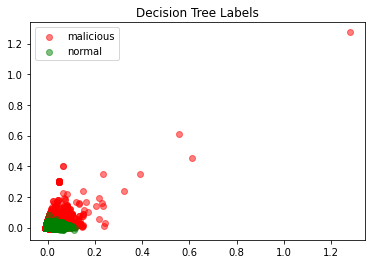

In [17]:
predicted = tree.predict(ds)

dp = pandas.DataFrame()
dp['label'] = predicted

filtered_label2 = dsp[dp["label"] == 0]
filtered_label =  dsp[dp["label"] == 1]

plt.title("Decision Tree Labels")
plt.scatter(filtered_label[:,0] , filtered_label[:,1] , color = 'red', alpha=0.5, label = "malicious")
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'green', alpha=0.5, label = "normal")
plt.legend()
plt.show()

The Decision Tree to perform relatively well, as expected this feature characterizes well some kinds of attacks, but not enough to cover all attacks in the dataset. Probably this feature can be the base for a rule set, it can be extracted from the tree.

In [43]:
features_name = list(ds.columns)
importance = tree.feature_importances_
importance = [(i,n) for i, n in zip(importance, features_name)]
importance.sort(reverse=True, key=(lambda x: x[0]))
print("Decision Tree features importance")
for i, n in importance:
    print(f"{n}: {round(i*100, 2)}%")

small_tree = DTC(max_depth=3) #small tree for better representation
small_tree = small_tree.fit(X_train, y_train)
rules = export_text(small_tree, feature_names=features_name, max_depth=3)

print("\nDecision Tree rules (truncated depth 3)")
print(rules)

Decision Tree features importance
shell: 71.03%
query_len: 18.63%
length: 5.41%
script: 3.14%
sql: 1.78%

Decision Tree rules (truncated depth 3)
|--- shell <= 1.50
|   |--- query_len <= 1.50
|   |   |--- length <= 8.50
|   |   |   |--- class: 1
|   |   |--- length >  8.50
|   |   |   |--- class: 0
|   |--- query_len >  1.50
|   |   |--- query_len <= 35.50
|   |   |   |--- class: 1
|   |   |--- query_len >  35.50
|   |   |   |--- class: 0
|--- shell >  1.50
|   |--- shell <= 3.50
|   |   |--- sql <= 0.50
|   |   |   |--- class: 1
|   |   |--- sql >  0.50
|   |   |   |--- class: 1
|   |--- shell >  3.50
|   |   |--- query_len <= 56.50
|   |   |   |--- class: 1
|   |   |--- query_len >  56.50
|   |   |   |--- class: 1



**Classification - second approach**

In the second approach presented, instead of extracting features based on domain knowledge the URLs are vectorized using TfidfVectorizer. For performance reasons, the set of the tokens is reduced to the bests 800, discarding the most frequent 10%, which are likely to be in common between normal and malicious examples.
The same studied algorithms are compared. The Logistic Regression is set with a higher number of iterations to ensure convergence, the MLPClassifier with a limited number of epochs, and the Decision Tree with a limited depth for performance reasons, but this has no significant impact on the models' accuracy.

In [22]:
y = df["label"].map(lambda x: 1 if x == "malicious" else 0)
X = df['url']
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3), max_df=0.9, max_features=800) 
X = vectorizer.fit_transform(X)


In [23]:

lr = LogisticRegression(max_iter=1500)
nb = MultinomialNB()
svm = SVM()
nn = MLPClassifier(max_iter=4)
tree = DTC(max_depth=10)

classifiers = [(nb, 'Naive Bayes'), (lr, 'Logistic Regression'), (tree, 'Decision Tree'), (svm, 'SVM'), (nn, 'MLPClassifier')]

rus = RandomUnderSampler(sampling_strategy=0.2) #undersampling to reduce unbalance
X, y = rus.fit_resample(X, y)

result = []

for cls, name in classifiers:
    skfold=StratifiedKFold(random_state=42, shuffle=True)
    scores=cross_val_score(cls,X,y,cv=skfold, scoring='f1', n_jobs=4)
    result.append((name, np.mean(scores)))

result.sort(reverse=True, key=(lambda x: x[1]))
print("Classifier, F1-Score")
for r in result:
    print(f"{r[0]} {r[1]}")


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier, F1-Score
MLPClassifier 0.9932574988835847
SVM 0.9915624912917436
Logistic Regression 0.9837498952346527
Decision Tree 0.9629284051408191
Naive Bayes 0.8908195543126449


All the classifiers except for the Naive Bayes have a very high score value. The MLPClassifier has a similar score to SVM but it is significantly heavier in terms of computation. Even the Decision tree is slower than SVM and Logistic Regression but can be analyzed to learn about feature importance. So Logistic Regression and SVM are compared, and the best classifier is analyzed. The comparison is performed on the full set of tokens except for the most frequent 1%.

In [44]:
y = df["label"].map(lambda x: 1 if x == "malicious" else 0)
X = df['url']
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3), max_df=0.99) 
X = vectorizer.fit_transform(X)

In [28]:
lr = LogisticRegression(max_iter=1500)
svm = SVM()


classifiers = [(lr, 'Logistic Regression'), (svm, 'SVM')]

rus = RandomUnderSampler(sampling_strategy=0.2) #undersampling to reduce unbalance
X_train, y_train = rus.fit_resample(X, y)

result = []

for cls, name in classifiers:
    skfold=StratifiedKFold(random_state=42, shuffle=True, n_splits=10)
    scores=cross_val_score(cls,X_train,y_train,cv=skfold, scoring='f1', n_jobs=4)
    result.append((name, scores))

_, pvalue = wilcoxon(result[0][1], result[1][1])
print(f"pvalue: {pvalue}")
result = [(n, np.mean(s)) for n,s in result]
result.sort(reverse=True, key=(lambda x: x[1]))
print("Classifier, F1-Score")
for r in result:
    print(f"{r[0]} {r[1]}")

pvalue: 0.001953125
Classifier, F1-Score
SVM 0.9982454416068223
Logistic Regression 0.9907183059097721


Precision: 0.993799
Accuracy: 0.999659
Recall: 0.996181
F1-Score: 0.994989


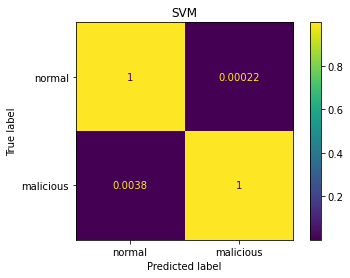

In [47]:
cls = SVM()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
cls = cls.fit(X_train, y_train)
predicted = cls.predict(X_test)

print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Accuracy: %f" % metrics.accuracy_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
matrix = metrics.confusion_matrix(y_test, predicted, normalize='true', labels=[0,1])
matrix = display_cm(matrix, display_labels=['normal', 'malicious'])
matrix.plot()
matrix.ax_.set_title("SVM")
plt.show()

SVM is the most accurate and fastest classifier. The undersampling ratio 0.2 is a good trade off between the correct prediction on the two classes.
The Decision tree can be used to know the most important n-gram in the classification.

Precision: 0.991100
Accuracy: 0.999158
Recall: 0.984050
F1-Score: 0.987562


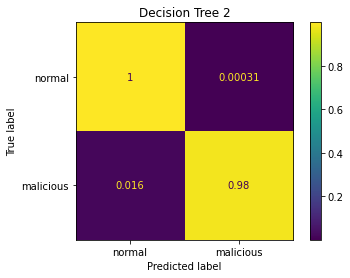

Decision Tree features importance
'=': 43.17%
')': 13.64%
'=ht': 10.25%
'.ex': 6.64%
'<': 5.05%
'..': 2.87%
'pts': 2.72%
"'": 1.96%
'ipt': 1.88%
'fiu': 1.32%


In [46]:
tree = DTC(max_depth=20)
tree = tree.fit(X_train, y_train)
predicted = tree.predict(X_test)
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Accuracy: %f" % metrics.accuracy_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
matrix = metrics.confusion_matrix(y_test, predicted, normalize='true', labels=[0,1])
matrix = display_cm(matrix, display_labels=['normal', 'malicious'])
matrix.plot()
matrix.ax_.set_title("Decision Tree 2")
plt.show()

importance = tree.feature_importances_
features_name = vectorizer.get_feature_names_out()
importance = [(i,n) for i, n in zip(importance, features_name)]
importance.sort(reverse=True, key=(lambda x: x[0]))
importance = importance[0:10]
   


print("Decision Tree features importance")
for i,n in importance:
    print(f"{repr(n)}: {round(i*100, 2)}%")

The Decision Tree returns as most important feature: 
- '=', ')' and '>' used in various type of injection attacks
- '.ex' part of the string ".exe"
- '=ht': part of the string '=http', used in HTTP header injection
- '..' used in path traversal and Shell Injection
- 'pts': part of the string '/scripts', related with PHP-based attacks
- "'" used in SQL Injection
- 'ipt': part of the string 'script' used in JSInjection

So this feature can be linked to common attacks.

**Novelty Detection**

The last approach uses only normal examples to train a novelty detection model. This approach is reasonable in the context of web server protection because is not easy to have examples of attacks. Unfortunately, this approach does not seem to have satisfying results.


Precision: 0.769114
Accuracy: 0.491941
Recall: 0.575383
F1-Score: 0.658291


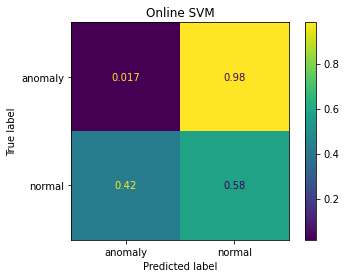

In [36]:
ds = df[["sql", "query_len", "shell", "script", "length"]]
ds = preprocessing.MinMaxScaler().fit_transform(ds)
normal = ds[df['label'] == "normal"]
normal_len = len(normal)
yn = [1 for _ in range(normal_len)]
anomalous = ds[df['label'] == "malicious"]
anomalous_len = len(anomalous)
ya = [-1 for _ in range(anomalous_len)]

X_train, X_test, y_train, y_test = train_test_split(normal, yn, test_size=0.2, random_state=42)
X_test = np.concatenate((X_test, anomalous))
y_test += ya

cls = OSVM()

cls = cls.fit(X_train)
predicted = cls.predict(X_test)

print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Accuracy: %f" % metrics.accuracy_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
matrix = display_cm(metrics.confusion_matrix(y_test, predicted, normalize='true'), display_labels=['anomaly', 'normal'])
matrix.plot()
matrix.ax_.set_title("Online SVM")
plt.show()